<div style="border-radius:10px; padding: 12px; background-color:; font-size:130%; text-align:left">

 <h2 align="left"><font color=#E1B12D>Introduction</font></h2>
    
The objective is to categorize faults in steel plates into seven distinct types. We will utilize various machine learning algorithms to identify and classify the defects.

Fault diagnosis entails identifying deviations in a system's characteristics from its typical performance. The primary goal of any fault diagnosis system is to precisely identify potential faults' locations and timing using available data and knowledge of system performance. Traditionally, manual fault diagnosis involves experts using electronic meters to gather equipment operation information, consulting maintenance manuals, and inferring likely fault causes.<br>
    </div>
    

<a id="3"></a>
## <b> ⚙ <span style='color:#E1B12D'>  Setting up the notebook</span></b> 


In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def insert_image(path, zoom, xybox, ax):
    '''Insert an image within matplotlib'''
    imagebox = OffsetImage(mpimg.imread(path), zoom=zoom)
    ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), frameon=False, pad=1, xybox=xybox)
    ax.add_artist(ab)

In [2]:
train=pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
test =pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv') 
original = pd.read_csv('/kaggle/input/steel-plates-faults-from-uci/Steel Plates Faults.csv')

<a id="3"></a>
## <b> <span style='color:#E1B12D'> 📋 Data Overview </span></b> 


In [3]:
print("Sample of Train dataset")
pd.set_option('display.max_columns', None)
train.head().style.set_caption("").set_properties(**{'border': '1.5px dotted', 'color': ''})

Sample of Train dataset


,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.739300,0.400000,0.500000,0.005900,1.000000,1.000000,0.000000,1.204100,0.903100,0.699000,-0.500000,-0.010400,0.141700,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.777200,0.287800,0.258100,0.004400,0.250000,1.000000,1.000000,2.636500,0.778200,1.732400,0.741900,-0.299700,0.949100,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.055700,0.528200,0.989500,0.107700,0.236300,0.385700,0.000000,4.056400,2.179000,2.209500,-0.010500,-0.094400,1.000000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.720200,0.333300,0.333300,0.004400,0.375000,0.931000,1.000000,2.322200,0.778200,1.431400,0.666700,-0.040200,0.402500,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.121100,0.534700,0.084200,0.019200,0.210500,0.986100,1.000000,2.769400,1.415000,1.880800,0.915800,-0.245500,0.999800,0,0,0,0,0,0,1


In [4]:
print("Sample of Test dataset")
test.head().style.set_caption("").set_properties(**{'border': '1.5px dotted', 'color': ''})

Sample of Test dataset


,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,1656,0,1,150,0.387700,0.489600,0.327300,0.009500,0.565200,1.000000,1.000000,2.841000,1.113900,1.662800,0.672700,-0.226100,0.917200
1,19220,1257,1271,419960,419973,370,26,28,39293,92,132,1354,0,1,40,0.162900,0.413600,0.093800,0.004700,0.241400,1.000000,1.000000,2.568200,0.903100,1.447200,0.906300,-0.145300,0.910400
2,19221,1358,1372,117715,117724,289,36,32,29386,101,134,1360,0,1,40,0.060900,0.623400,0.476200,0.015500,0.600000,0.750000,0.000000,2.460900,1.322200,1.322200,-0.523800,-0.043500,0.651400
3,19222,158,168,232415,232440,80,10,11,8586,107,140,1690,1,0,100,0.443900,0.333300,0.818200,0.003700,0.800000,1.000000,1.000000,1.903100,0.699000,1.041400,0.181800,-0.073800,0.205100
4,19223,559,592,544375,544389,140,19,15,15524,103,134,1688,1,0,60,0.819100,0.261900,0.428600,0.015800,0.842100,0.533300,0.000000,2.146100,1.322200,1.146100,-0.571400,-0.089400,0.417000


In [5]:
train.drop(columns=['id'], inplace=True)
def summary(df):
    summry = pd.DataFrame(df.dtypes, columns=['data type'])
    summry['#missing'] = df.isnull().sum().values
    summry['Duplicate'] = df.duplicated().sum()
    summry['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summry['min'] = desc['min'].values
    summry['max'] = desc['max'].values
    summry['mean'] = desc['mean'].values
    summry['median'] = desc['50%']
    summry['std dev'] = desc['std'].values
    return summry

In [6]:
summary(train).style.set_caption("<b>Summary of the Train Data</b>").\
background_gradient().set_properties(**{'border': '1.5px dotted', 'color': ''})

,data type,#missing,Duplicate,#unique,min,max,mean,median,std dev
X_Minimum,int64,0,0,1191,0.000000,1705.000000,709.854675,777.000000,531.544189
X_Maximum,int64,0,0,1259,4.000000,1713.000000,753.857641,796.000000,499.836603
Y_Minimum,int64,0,0,3345,6712.000000,12987661.000000,1849756.040012,1398169.000000,1903553.850679
Y_Maximum,int64,0,0,3341,6724.000000,12987692.000000,1846605.345439,1398179.000000,1896295.137914
Pixels_Areas,int64,0,0,1154,6.000000,152655.000000,1683.987616,168.000000,3730.319865
X_Perimeter,int64,0,0,460,2.000000,7553.000000,95.654665,25.000000,177.821382
Y_Perimeter,int64,0,0,331,1.000000,903.000000,64.124096,23.000000,101.054178
Sum_of_Luminosity,int64,0,0,2595,250.000000,11591414.000000,191846.678235,18238.000000,442024.694057
Minimum_of_Luminosity,int64,0,0,162,0.000000,196.000000,84.808419,90.000000,28.800344
Maximum_of_Luminosity,int64,0,0,98,39.000000,253.000000,128.647380,127.000000,14.196976


<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left">
<p style="color: #3476a8; font-family: 'verdana'; font-size: 16px; font-weight: bold;"> ⌱ Insights: </p>
    
✧ The dataset consists of primarily integer and float data types with  19,219 rows across 26 features.<br>
✧ There are no missing values or duplicates in the dataset.<br>
✧ Features exhibit a wide range of values, with some features having a small range (e.g., TypeOfSteel_A300 and TypeOfSteel_A400) and others having a larger range (e.g., Y_Minimum and Y_Maximum).<br>
✧ There are 7 binary target variables indicating different types of defects in the steel plates. Datatype for analysis to be corrected for the target variables<br>
    </div>

<a id="3"></a>
## <b> <span style='color:#E1B12D'> 📊 Data Visualization </span></b> 


In [7]:
#Let's Create a single target variable
target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
def combine_target_variables(row):
    defect = None
    for col in target_columns:
        if row[col] == 1:
            defect = col
            break
    if defect:
        return defect
    else:
        return 'No Defect'
train['Target'] = train.apply(combine_target_variables, axis=1)
original['Target'] = original.apply(combine_target_variables, axis=1)

In [8]:
# Checabsk if two or more of the target columns have the defect
defect_count = train[target_columns].sum(axis=1)
multiple_defects_rows = train[defect_count >= 2]
# Original data
defect_count_og = original[target_columns].sum(axis=1)
multiple_defects_og = original[defect_count_og >= 2]
#Let's add No Defects column as well wherever there is no defect:
train['No_Defect'] = (defect_count == 0).astype(int)
original['No_Defect'] = (defect_count_og == 0).astype(int)

num_multiple_og = len(multiple_defects_og)
print(f"Number of rows with multiple defects In Original Data: {num_multiple_og}\n")
num_multiple_defects = len(multiple_defects_rows)
print(f"Number of rows with multiple defects: {num_multiple_defects}\n")
display("Head of rows with multiple defects:\n", multiple_defects_rows.head())


Number of rows with multiple defects In Original Data: 0

Number of rows with multiple defects: 21



'Head of rows with multiple defects:\n'

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,Target
634,41,192,1682722,1682891,9927,578,343,1098162,29,141,1402,0,1,40,0.0585,0.4970,0.9408,0.1054,0.2390,0.3925,1.0,3.9968,1.0000,2.2175,0.0592,-0.1071,1.000,0,0,1,0,0,0,1,K_Scatch
752,39,194,2134009,2134076,10904,562,360,1130960,32,141,1400,0,1,40,0.0557,0.5917,0.3478,0.1107,0.2672,0.4615,1.0,4.0379,2.1931,2.1761,0.6522,-0.1031,0.463,0,0,1,0,0,0,1,K_Scatch
3572,241,360,938265,938349,2027,178,118,241083,38,108,1360,0,1,40,0.2801,0.6670,0.4167,0.0553,0.2352,0.6377,0.0,3.3068,1.8751,1.8808,-0.5833,-0.3705,1.000,0,0,1,0,0,1,0,K_Scatch
4416,39,729,498078,498335,13114,976,453,1438454,29,143,1400,0,1,40,0.0586,0.6635,0.9558,0.1250,0.2656,0.4011,1.0,4.1150,2.2529,2.2355,0.0442,-0.0960,1.000,0,0,1,0,0,0,1,K_Scatch
4530,39,222,221142,2212144,10166,634,383,1130960,31,141,1400,0,1,40,0.0586,0.4647,0.9855,0.1293,0.2749,0.4355,1.0,4.0072,2.2529,2.2227,0.0145,-0.2199,1.000,0,0,1,0,0,0,1,K_Scatch


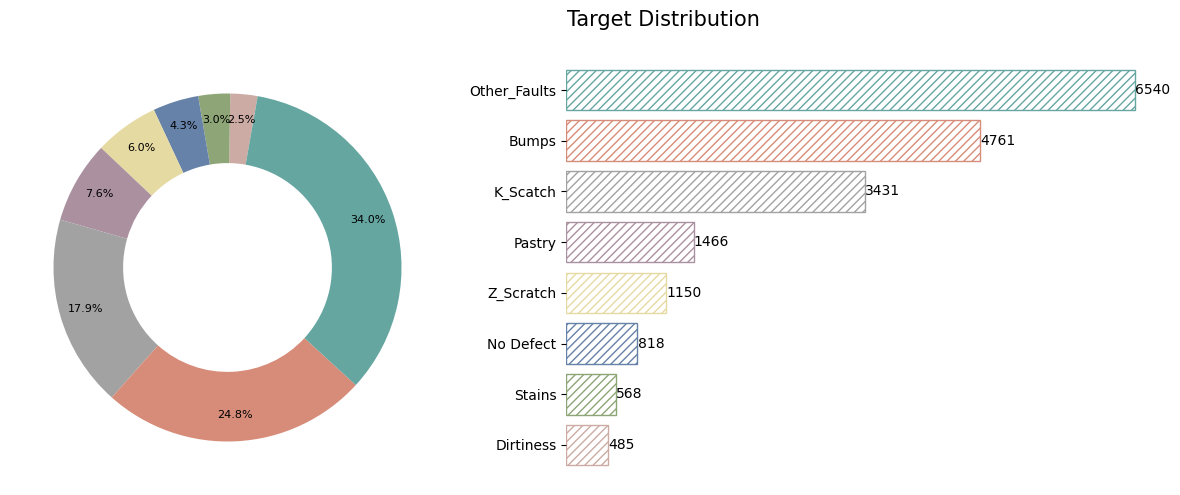

In [9]:
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()
value_counts = train['Target'].value_counts(ascending=True)
labels = value_counts.index.tolist()
colors = ["#ccaba4", '#8ea677', '#6782a8', '#e6daa3', '#ab90a0', '#a3a2a2', "#d68c78", "#65a6a1"]
# Donut Chart
wedges, texts, autotexts = ax[0].pie(
    value_counts, autopct='%1.1f%%', textprops={'size': 8, 'color': 'black'}, colors=colors,
    wedgeprops=dict(width=0.4), startangle=80, pctdistance=0.85)
centre_circle = plt.Circle((0, 0), 0.6, fc='none')
ax[0].add_artist(centre_circle)
# Count Plot 
for i, v in enumerate(value_counts):
    ax[1].barh(i, v, color='none', edgecolor=colors[i], hatch='////')
    ax[1].text(v + 1, i, str(v), color='black', fontsize=10, va='center')
ax[1].set_yticks(range(len(labels)))
ax[1].set_yticklabels(labels)
sns.despine(left=True, bottom=True)
plt.xticks(fontsize=9, color='black')
ax[1].set_ylabel(None)
plt.xlabel("")
ax[1].set_xticks([])
fig.suptitle('Target Distribution', fontsize=15)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Train Data - Individual Defect Distribution 


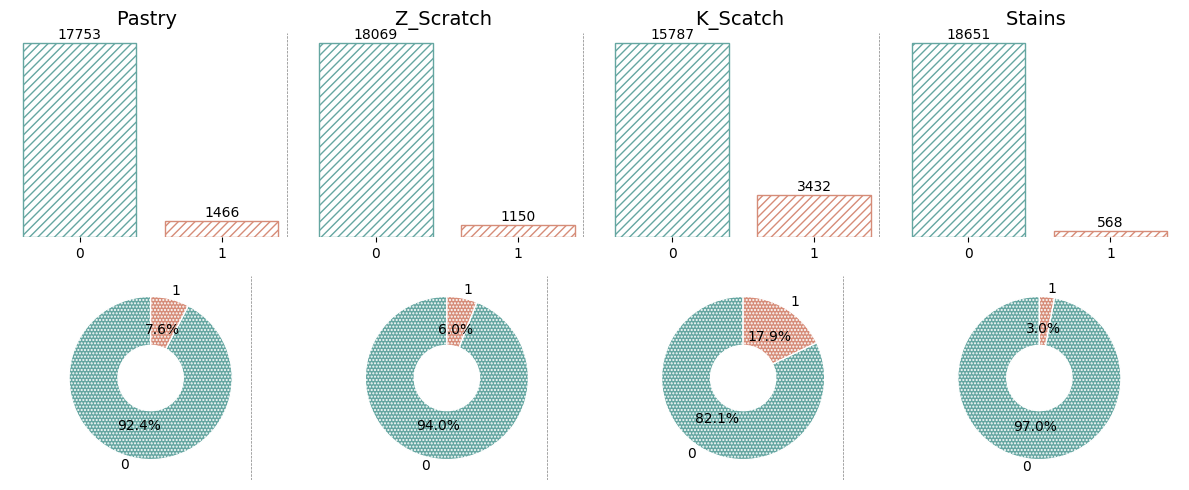

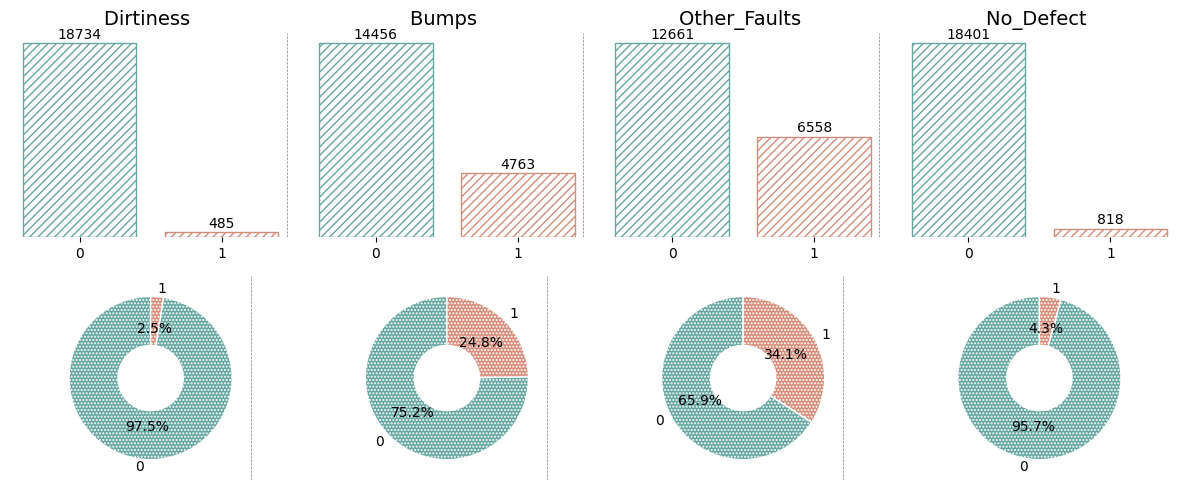

In [10]:
def plot_feature_distribution(features):
    fig, axes = plt.subplots(2, len(features), figsize=(12, 5))
    for i, feature in enumerate(features):
    # Bar plot 
        feature_distribution = data[feature].value_counts()
        labels = feature_distribution.index.tolist()
        values = feature_distribution.values.tolist()
        colors = ['#65a6a1', '#d68c78', '#e6daa3','#6782a8' ]  
        for j, (label, value) in enumerate(zip(labels, values)):
            axes[0, i].bar(j, value, color='white', edgecolor=colors[j], hatch='////')
        for p in axes[0, i].patches:
            axes[0, i].annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                                 ha = 'center', va = 'center', xytext = (0, 6),textcoords = 'offset points',fontsize=10)
        axes[0, i].set_xlabel('')
        axes[0, i].set_title(f'{feature} ', fontsize=14)
        axes[0, i].set_ylabel('')
        axes[0, i].set_yticks([])
        axes[0, i].set_xticks([0, 1])  
        axes[0, i].set_xticklabels(labels) 
    # Donut chart
        percentages = [(value / sum(values)) * 100 for value in values]
        axes[1, i].pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.6, edgecolor='white', linewidth=1, hatch='.....'), textprops={'fontsize': 10})
        if i < len(features) - 1:
            axes[0, i].axvline(x=1.46, color='gray', linestyle='--', linewidth=0.5)
            axes[1, i].axvline(x=1.23, color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    sns.despine(left=True, bottom=True) 
    plt.show()
data =train.copy()
print("Train Data - Individual Defect Distribution ")
features = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains']
plot_feature_distribution(features)
features  = ['Dirtiness', 'Bumps', 'Other_Faults', 'No_Defect']
plot_feature_distribution(features)

Original Data - Individual Defect Distribution


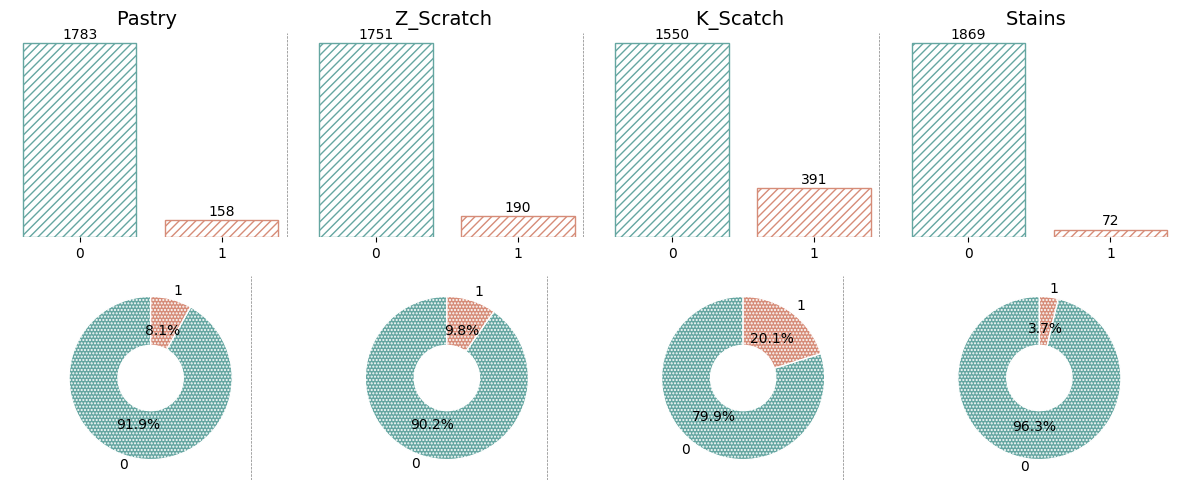

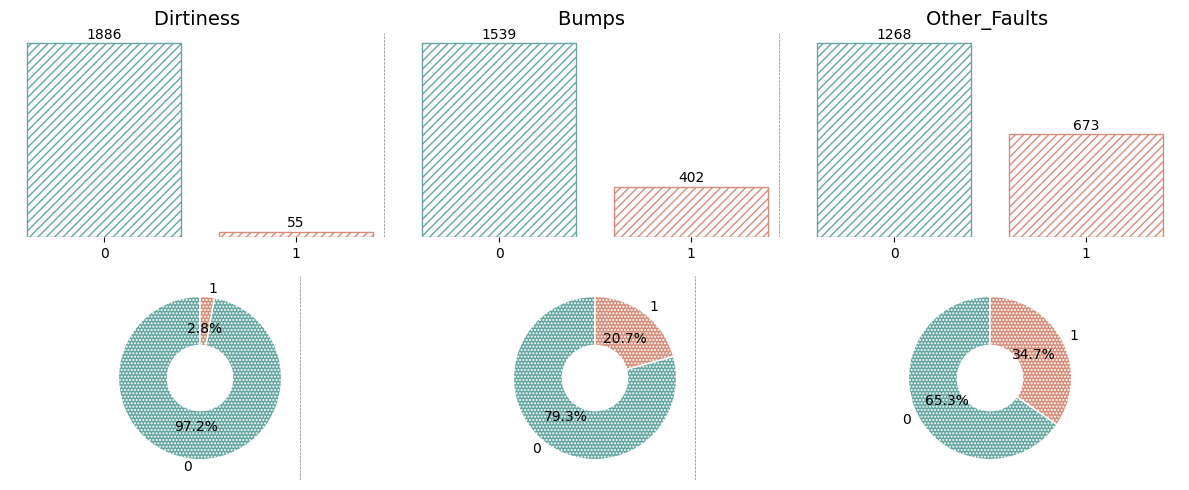

In [11]:
#Original Data target distribution
print("Original Data - Individual Defect Distribution")
data= original.copy()
features = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains']
plot_feature_distribution(features)
features  = ['Dirtiness', 'Bumps', 'Other_Faults']
plot_feature_distribution(features)

<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left">
✧ There are 21 instances wherein there are more than 1 defect, while in original dataset, there are only 1 defect acorss 1 id<br>
✧ Because of this the combined Target distribution & individual distribution varies a bit<br>    
✧ Train Data distribution is almost similar to the original data.<br>
    </div>

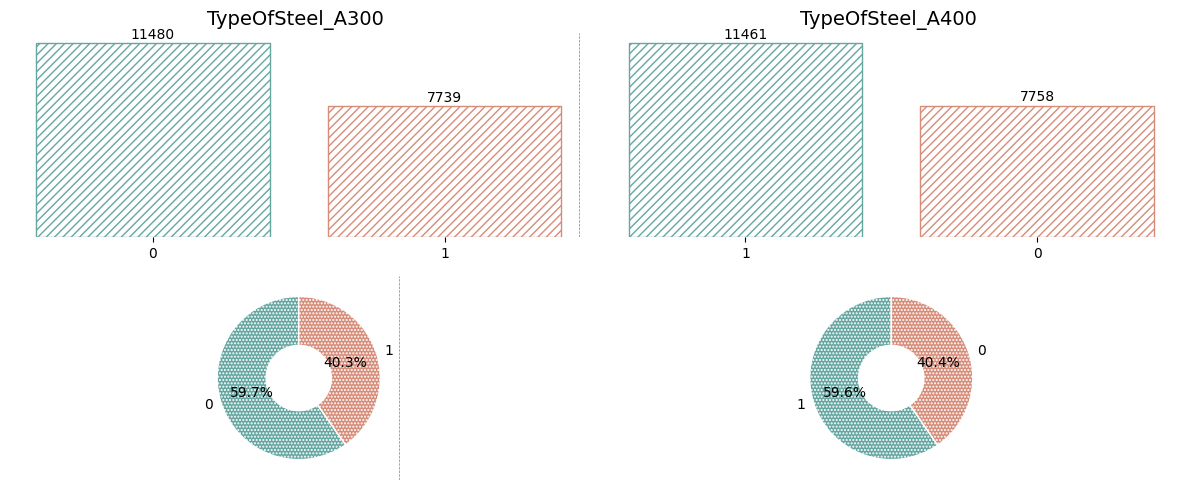

In [12]:
data= train.copy()
features = ['TypeOfSteel_A300', 'TypeOfSteel_A400']
plot_feature_distribution(features)

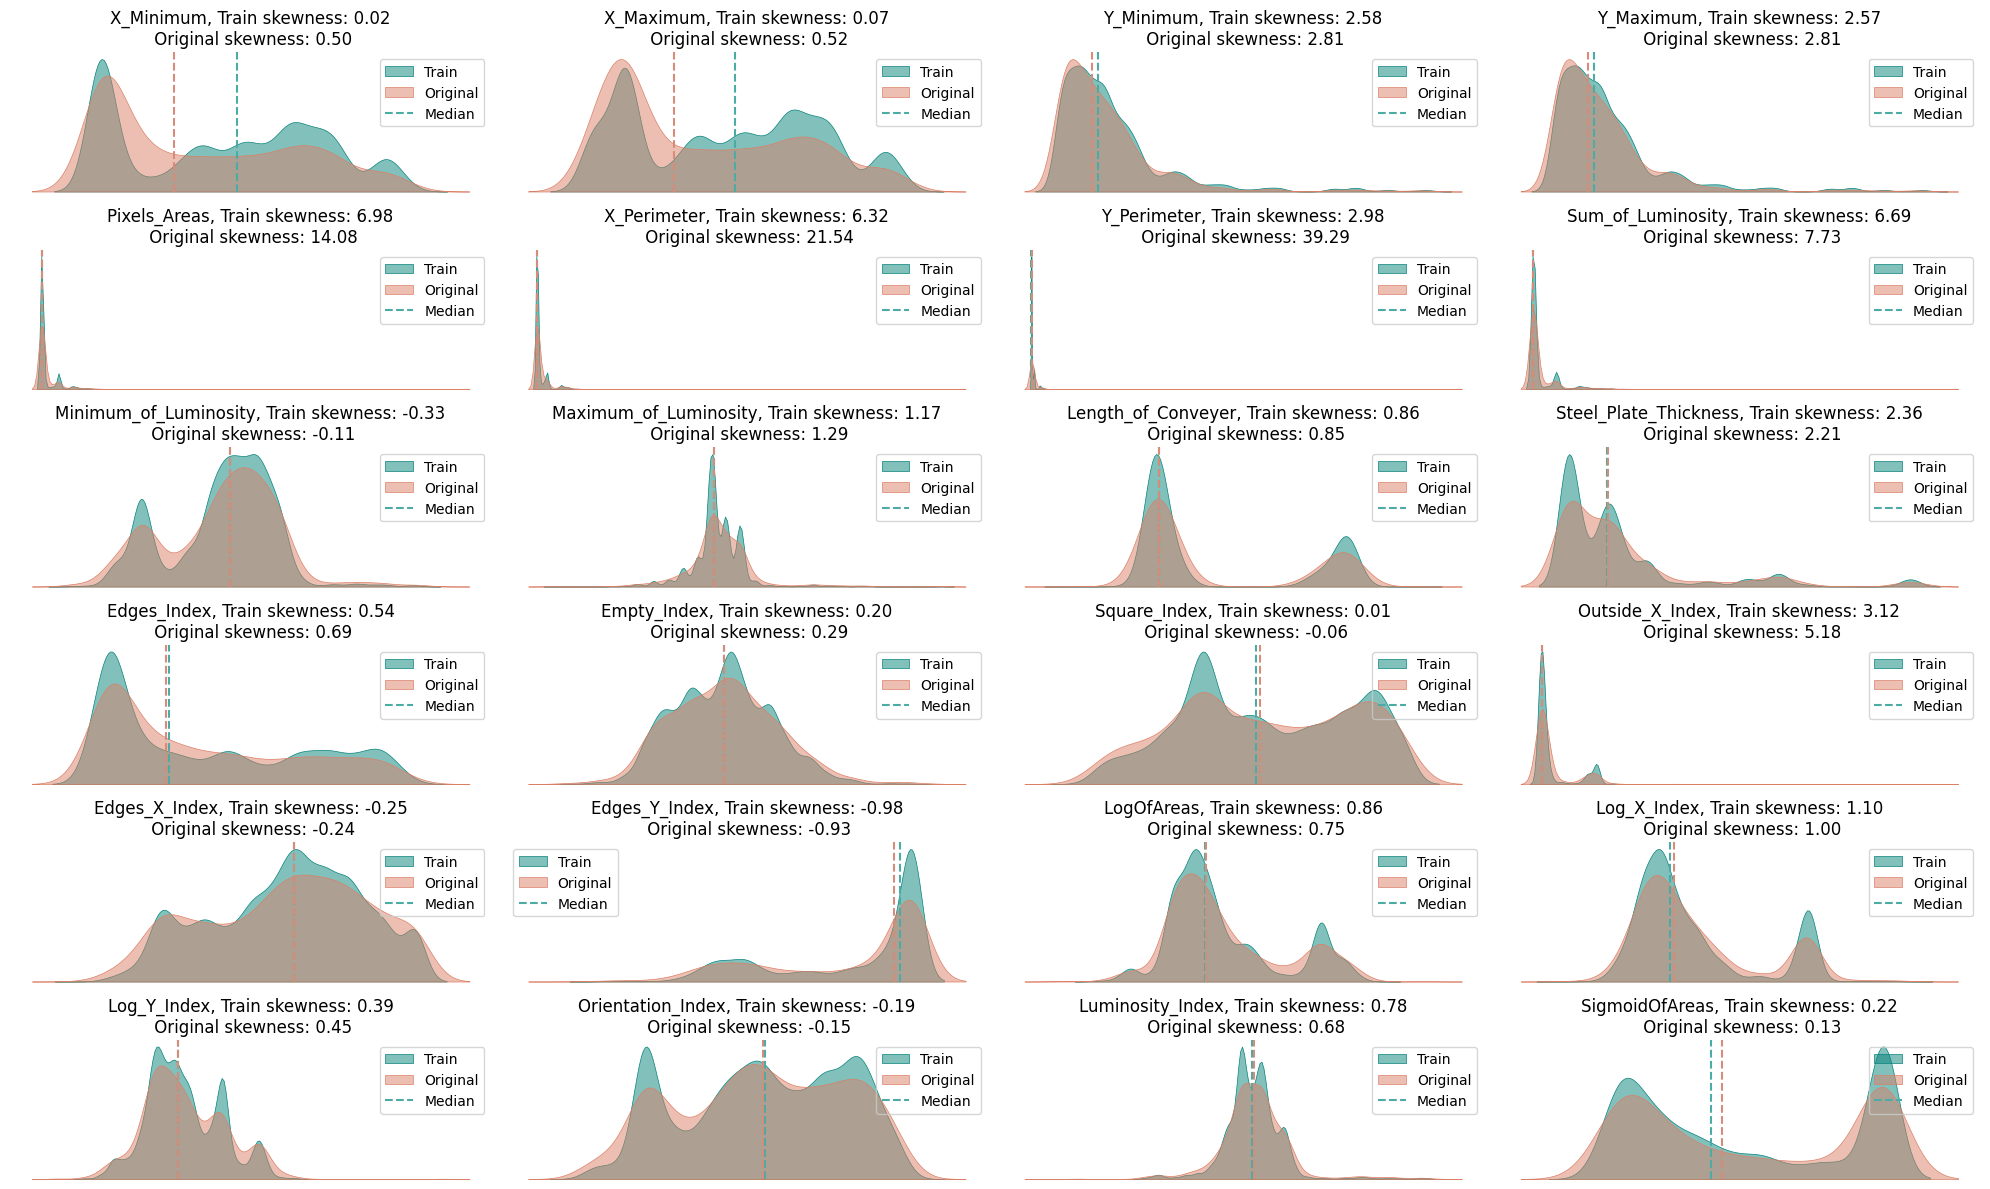

In [13]:
# Checking for distributions
columns_todrop = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'TypeOfSteel_A400', 'TypeOfSteel_A300','Outside_Global_Index','No_Defect']
numeric_columns = train.select_dtypes(include=['float64', 'int64']).drop(columns=columns_todrop, axis=1)
def dist(train_dataset, original_dataset, columns_list, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(20, 12))
    axs = axs.flatten()
    for i, col in enumerate(columns_list):
        sns.kdeplot(train_dataset[col], ax=axs[i], fill=True, alpha=0.5, linewidth=0.5, color='#058279', label='Train')
        sns.kdeplot(original_dataset[col], ax=axs[i], fill=True, alpha=0.5, linewidth=0.5, color='#db8067', label='Original')
        axs[i].set_title(f'{col}, Train skewness: {train_dataset[col].skew():.2f}\n Original skewness: {original_dataset[col].skew():.2f}')
        axs[i].legend()
        axs[i].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        median_train = train_dataset[col].median()
        median_org = original_dataset[col].median()
        axs[i].axvline(x=median_train, color='#4caba4', linestyle='--')
        axs[i].axvline(x=median_org, color='#d68c78', linestyle='--')
        axs[i].legend(labels=['Train', 'Original', 'Median'])
    plt.tight_layout()
    sns.despine(left=True, bottom=True) 
dist(train_dataset=train, original_dataset=original, columns_list=numeric_columns.columns, rows=6, cols=4)

<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left">
✦ The data is skewed heavily while the distribution of Train & Original dataset are faily similar

In [14]:
from scipy.stats import skew
def identify_skewed_features(data, threshold=0.5):
    skewed_features = []
    for feature in numeric_columns:
        skewness = skew(data[feature])
        if abs(skewness) > threshold:
            skewed_features.append(feature)
            print(f"Feature '{feature}' is skewed (skewness: {skewness:.2f})")
    if not skewed_features:
        print("No skewed features found.")
    return skewed_features

skewed_features = identify_skewed_features(train)

Feature 'Y_Minimum' is skewed (skewness: 2.58)
Feature 'Y_Maximum' is skewed (skewness: 2.57)
Feature 'Pixels_Areas' is skewed (skewness: 6.98)
Feature 'X_Perimeter' is skewed (skewness: 6.32)
Feature 'Y_Perimeter' is skewed (skewness: 2.98)
Feature 'Sum_of_Luminosity' is skewed (skewness: 6.69)
Feature 'Maximum_of_Luminosity' is skewed (skewness: 1.17)
Feature 'Length_of_Conveyer' is skewed (skewness: 0.86)
Feature 'Steel_Plate_Thickness' is skewed (skewness: 2.36)
Feature 'Edges_Index' is skewed (skewness: 0.54)
Feature 'Outside_X_Index' is skewed (skewness: 3.12)
Feature 'Edges_Y_Index' is skewed (skewness: -0.98)
Feature 'LogOfAreas' is skewed (skewness: 0.86)
Feature 'Log_X_Index' is skewed (skewness: 1.10)
Feature 'Luminosity_Index' is skewed (skewness: 0.78)


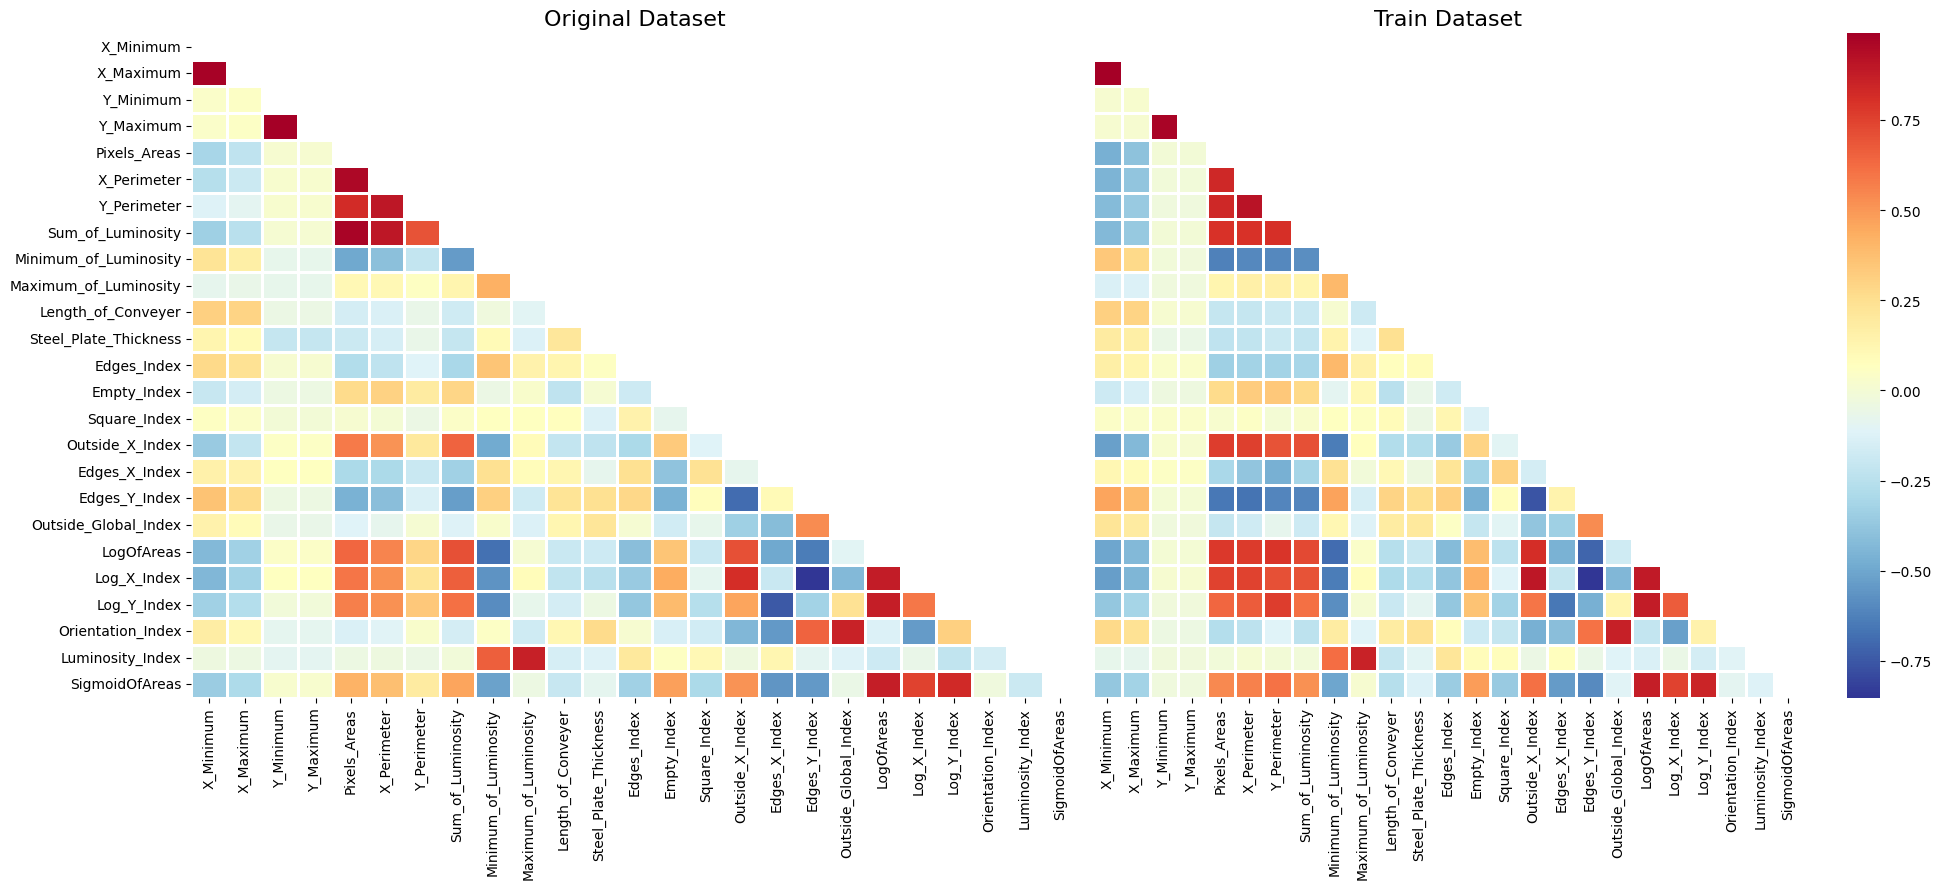

In [15]:
#Correlation heatmap
columns_todrop = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'TypeOfSteel_A400', 'TypeOfSteel_A300','No_Defect']
numeric_columns_original = original.select_dtypes(include=np.number).drop(columns=columns_todrop, axis=1)
numeric_columns_train = train.select_dtypes(include=np.number).drop(columns=columns_todrop, axis=1)
# original
corr_original = numeric_columns_original.corr(method='pearson')
mask_original = np.triu(np.ones_like(corr_original))
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
sns.heatmap(corr_original, annot=False, mask=mask_original, cmap='RdYlBu_r', cbar=None, linewidth=1, ax=axes[0])
axes[0].set_title('Original Dataset', fontsize=16)

# Train
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=False, mask=mask_train, cmap="RdYlBu_r", cbar=True, linewidth=2, ax=axes[1])
axes[1].set_title('Train Dataset', fontsize=16)
axes[1].set_yticks([])
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left">
    
 We can see strong positive as well as Negative correlation among many features.<br>
    
◉ Strong Positive Correlation:<br>
    
- X_Minimum and X_Maximum have a very strong positive correlation of approximately 0.99.<br>
- Y_Minimum and Y_Maximum also exhibit a very strong positive correlation of approximately 0.97.<br>

◉ Strong Negative Correlation:<br>
- Edge_Y_Index and Log_X_index show a strong negative correlation.<br>
- Log_Y_index and Edge_X_index have a strong negative correlation.<br>

◉ There are other features with High to moderate or low correlations <br>
    </div>

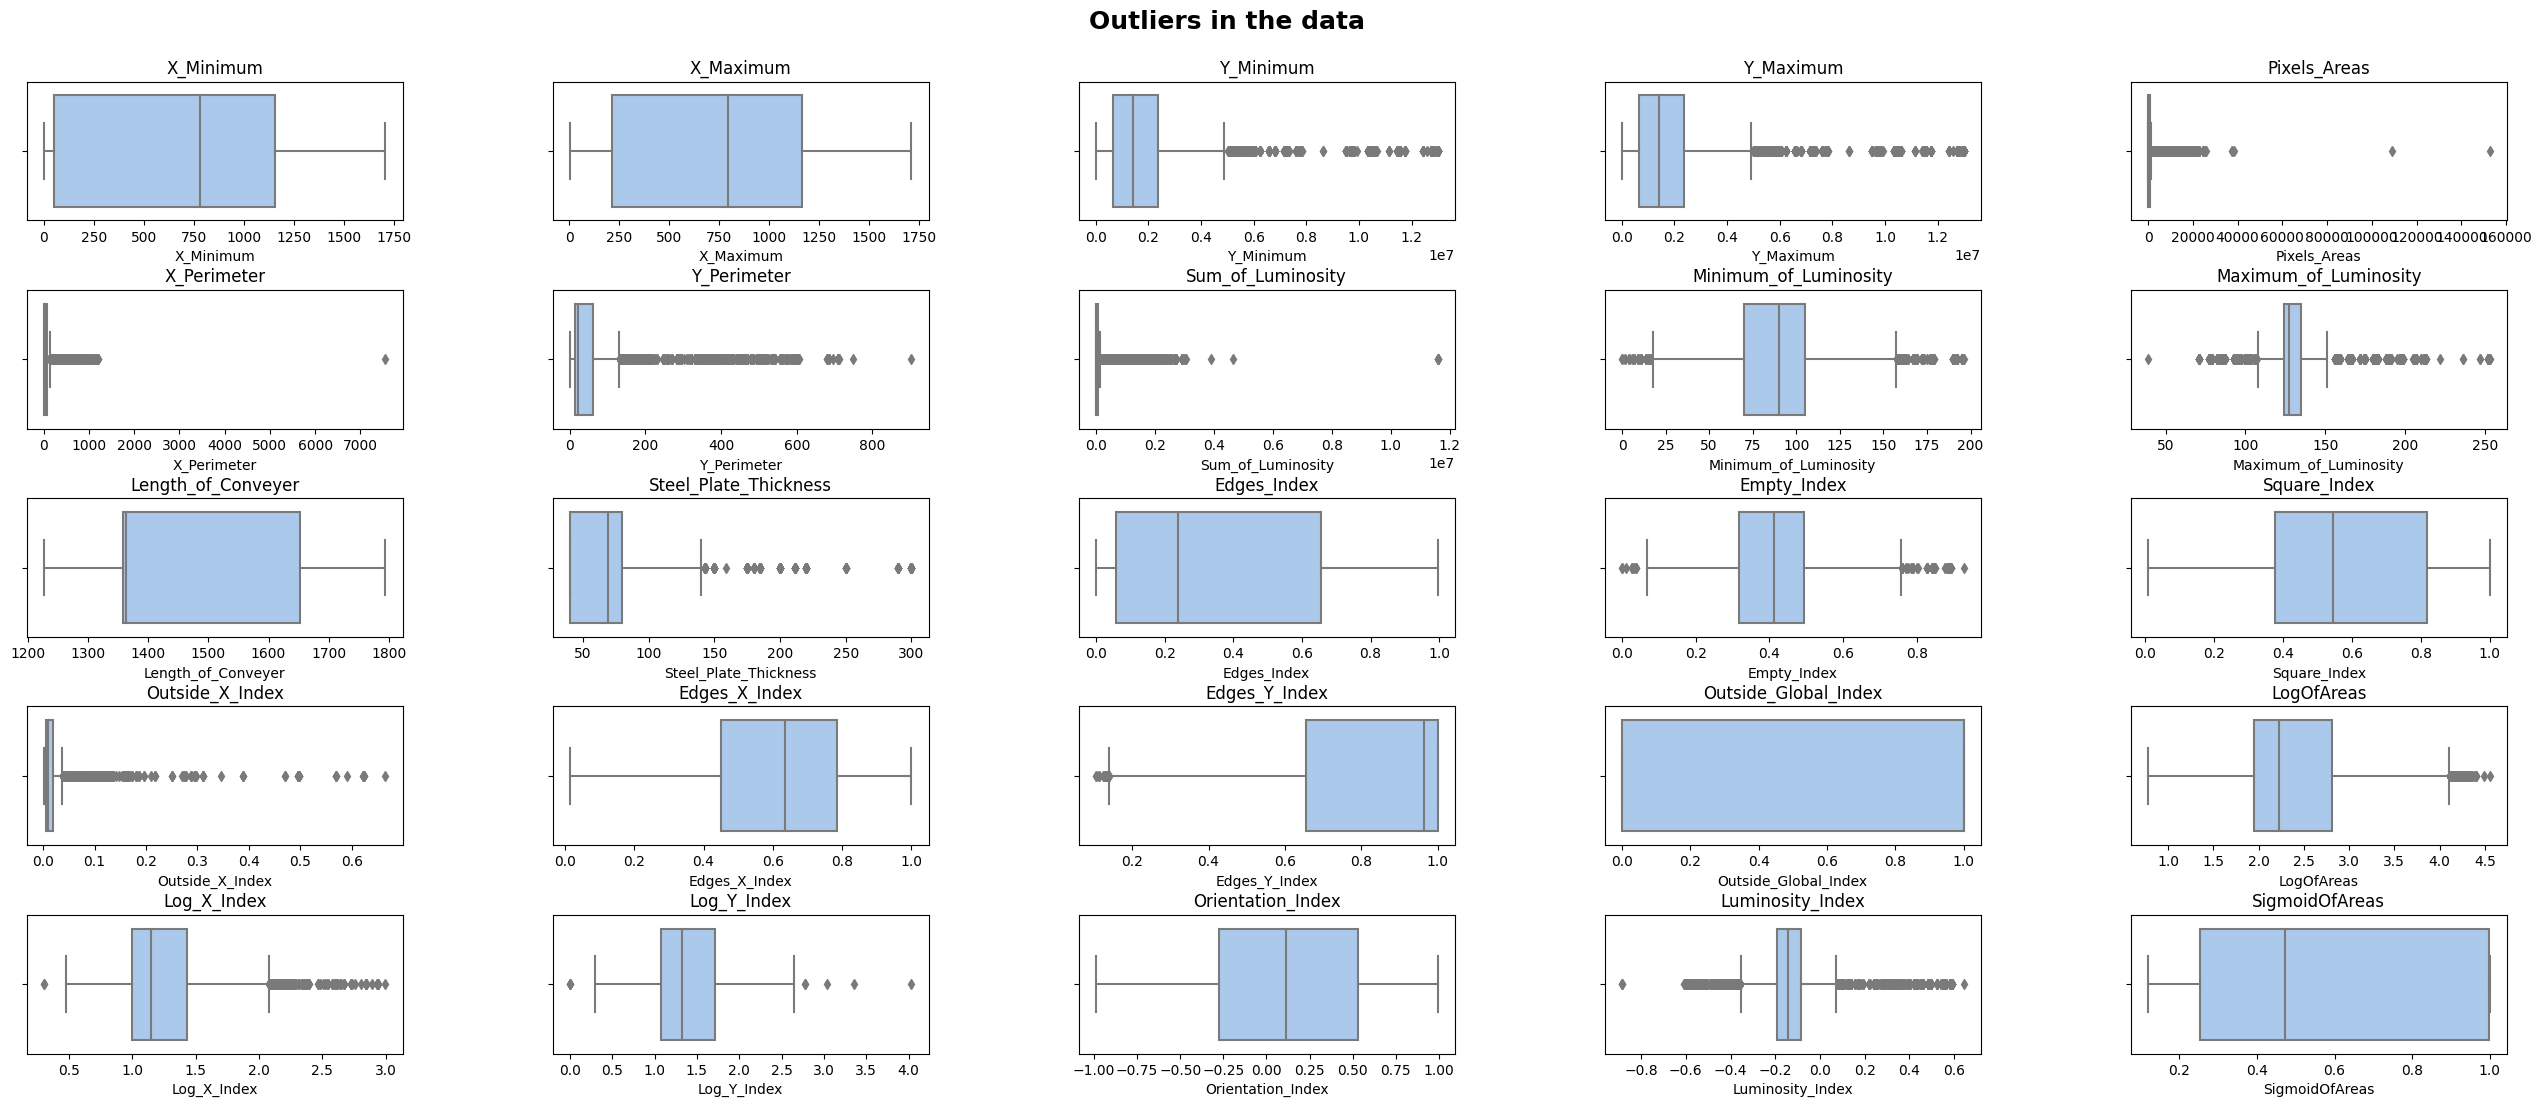

In [16]:
#Check for presence of outliers in each feature
fig = plt.figure(figsize=[32,12])
plt.suptitle('Outliers in the data', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(numeric_columns_train):
    ax = fig.add_subplot(5,5, i+1);
    ax = sns.boxplot(data = train, x=col, palette='pastel');
    ax.set_title(f'{col}')
    ax.set_xlabel(f'{col}')
    ax.grid(False)
plt.show()

<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left"> 
◉ Presence of Outlier is evident in mant features such as Y perimeter, Maximum of Luminosity, Luminosity Index

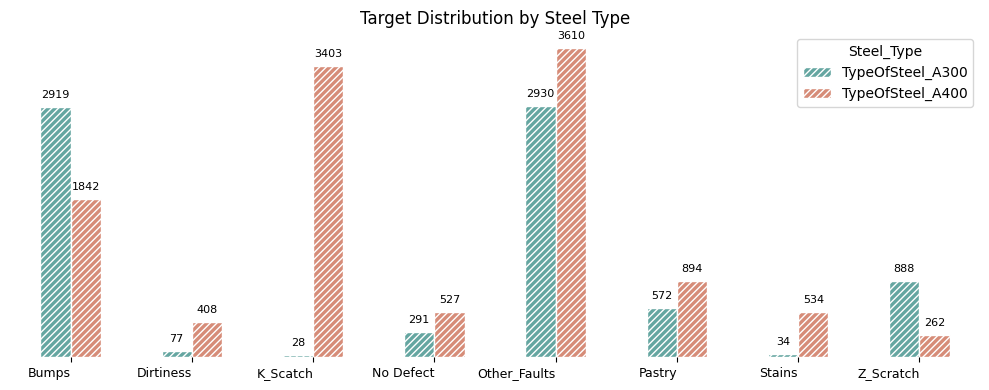

In [17]:
train['Steel_Type'] = train['TypeOfSteel_A300'].map({0: 'TypeOfSteel_A400', 1: 'TypeOfSteel_A300'})
value_counts = train.groupby(['Target', 'Steel_Type']).size().unstack(fill_value=0)
# Plot
ax = value_counts.plot(kind='bar', stacked=False, edgecolor='white', figsize=(10, 4), hatch='/////', color=['#65a6a1', '#d68c78'])
ax.legend(title="Steel_Type")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0, ha='right', fontsize=9)
plt.xlabel("")
plt.ylabel("")
plt.yticks([])
plt.title('Target Distribution by Steel Type', fontsize=12)
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left"> 
◉ A300 steel has higher defect type of Bump and Z scratch<br>
◉ A400 steel has higher defect type in rest. k_Scratch, is major in A400 <br>

<div style="border-radius:10px; padding: 12px; background-color: #; font-size:140%; text-align:left"> 

Let me try with the other features, can we visualize the defects? 

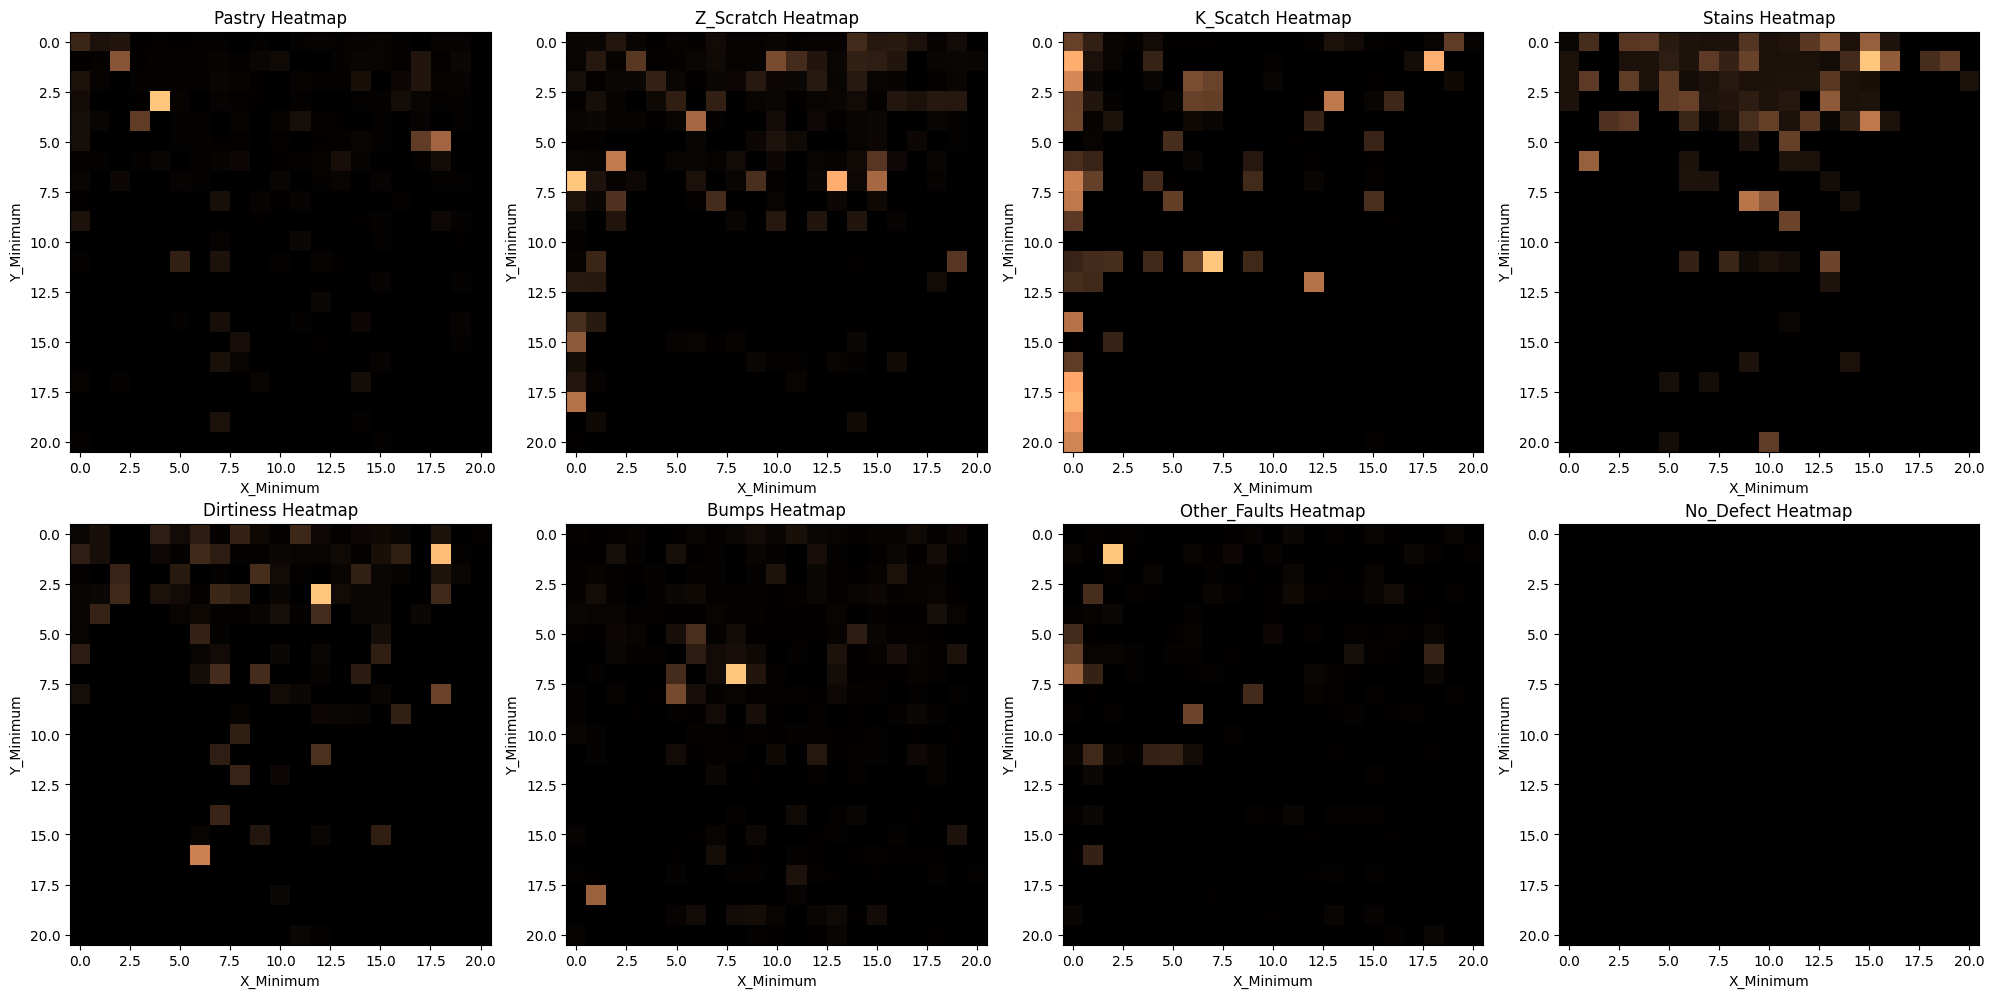

In [18]:
defect_types = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', "No_Defect"]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, defect_type in enumerate(defect_types):
    pixels_areas = train[train['Target'] == defect_type]['Pixels_Areas']
    x_coordinates = train[train['Target'] == defect_type]['X_Minimum']
    y_coordinates = train[train['Target'] == defect_type]['Y_Minimum']
    grid_size = 21
    heatmap_data = np.zeros((grid_size, grid_size))
    for pixel_area, x_coord, y_coord in zip(pixels_areas, x_coordinates, y_coordinates):
        grid_x = int(x_coord / (max(x_coordinates) - min(x_coordinates)) * (grid_size - 1))
        grid_y = int(y_coord / (max(y_coordinates) - min(y_coordinates)) * (grid_size - 1))
        heatmap_data[grid_y, grid_x] = pixel_area
    ax = axes[i // 4, i % 4]
    img = ax.imshow(heatmap_data, cmap='copper', interpolation='nearest')
    ax.set_xlabel('X_Minimum')
    ax.set_ylabel('Y_Minimum')
    ax.set_title(f'{defect_type} Heatmap')
plt.tight_layout()
plt.show()

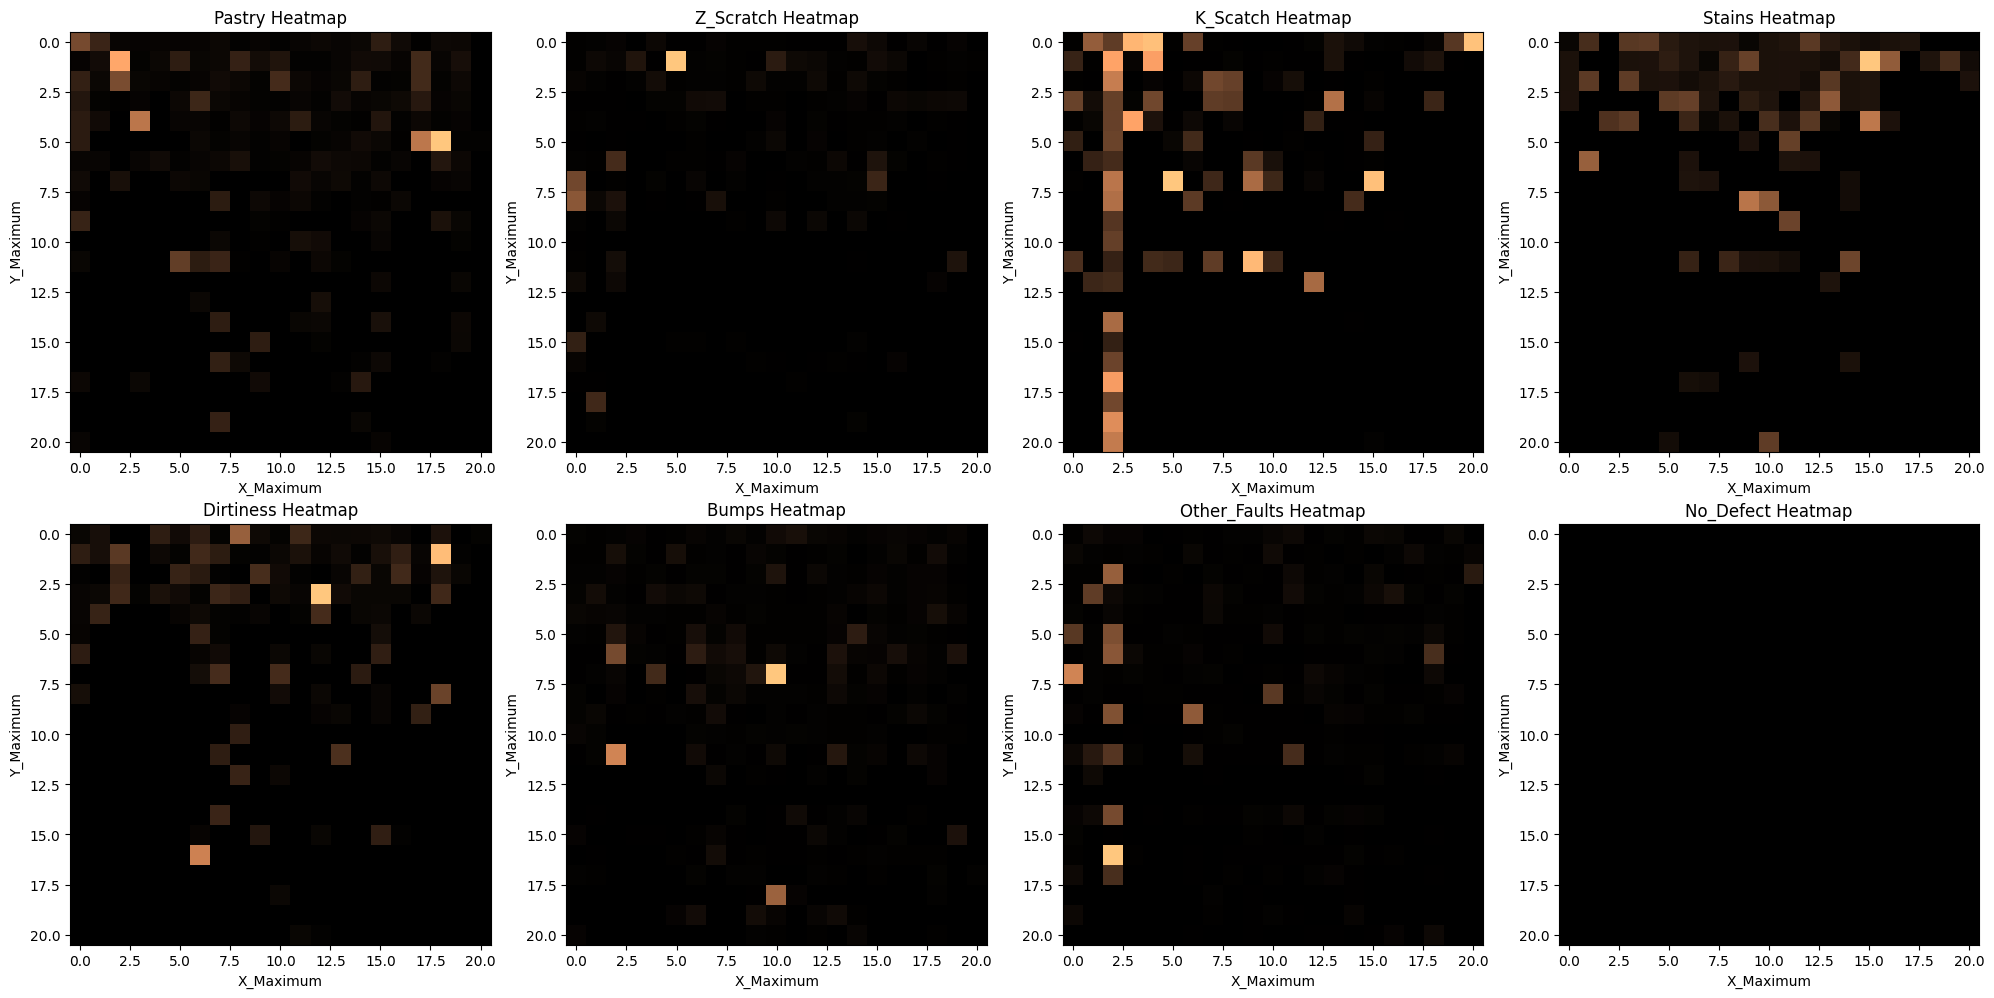

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, defect_type in enumerate(defect_types):
    pixels_areas = train[train['Target'] == defect_type]['Pixels_Areas']
    x_coordinates = train[train['Target'] == defect_type]['X_Maximum']
    y_coordinates = train[train['Target'] == defect_type]['Y_Maximum']
    grid_size = 21
    heatmap_data = np.zeros((grid_size, grid_size))
    for pixel_area, x_coord, y_coord in zip(pixels_areas, x_coordinates, y_coordinates):
        grid_x = int(x_coord / (max(x_coordinates) - min(x_coordinates)) * (grid_size - 1))
        grid_y = int(y_coord / (max(y_coordinates) - min(y_coordinates)) * (grid_size - 1))
        heatmap_data[grid_y, grid_x] = pixel_area
    ax = axes[i // 4, i % 4]
    img = ax.imshow(heatmap_data, cmap='copper', interpolation='nearest')
    ax.set_xlabel('X_Maximum')
    ax.set_ylabel('Y_Maximum')
    ax.set_title(f'{defect_type} Heatmap')
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left"> 
🤔 Does this makes any sense? I'm also trying to figure out... <br>

<center><img src='https://media3.giphy.com/media/Dh5q0sShxgp13DwrvG/200w.gif?cid=6c09b952gh2has72e3z35gfnkc6egc3dfshq99bp10d0sxce&ep=v1_gifs_search&rid=200w.gif&ct=g'height=200px width=300px /></center>

<center><img src='https://static.wixstatic.com/media/f9fc2d_91f5566b35114bc7b8e12cf7539b80fb~mv2.gif' width=400px /></center>

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="3"></a>
## <b> <span style='color:#E1B12D'> Creating New Features</span></b> 
<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left"> 
Adding features based on the <a href="https://www.kaggle.com/competitions/playground-series-s4e3/discussion/481016">discussion post</a> & <a href= "https://www.kaggle.com/code/lucamassaron/steel-plate-eda-xgboost-is-all-you-need"> Notebook  </a> by Luca Massaron.
</div>


In [20]:
def calculate_coordinate_range_features(data):
    data['X_Range'] = (data['X_Maximum'] - data['X_Minimum'])
    data['Y_Range'] = (data['Y_Maximum'] - data['Y_Minimum'])
    return data

train = calculate_coordinate_range_features(train)
original = calculate_coordinate_range_features(original)
test = calculate_coordinate_range_features(test)

In [21]:
def calculate_coordinate_centroid_features(data):    
    data['center_X'] = (data['X_Maximum'] - data['X_Minimum'])/2
    data['center_Y'] = (data['Y_Maximum'] - data['Y_Minimum'])/2
    return data

train = calculate_coordinate_centroid_features(train)
original = calculate_coordinate_centroid_features(original)
test = calculate_coordinate_centroid_features(test)

In [22]:
def calculate_size_ratio_features(data):
    data['Area_Perimeter_Ratio'] = data['Pixels_Areas'] / (data['X_Perimeter'] + data['Y_Perimeter'])
    return data

train = calculate_size_ratio_features(train)
original = calculate_size_ratio_features(original)
test = calculate_size_ratio_features(test)

In [23]:
def calculate_luminosity_range_feature(data):
    data['Luminosity_Range'] = (data['Maximum_of_Luminosity'] - data['Minimum_of_Luminosity'])
    return data
train = calculate_luminosity_range_feature(train)
original = calculate_luminosity_range_feature(original)
test = calculate_luminosity_range_feature(test)

In [24]:
def calculate_luminosity_intensity_feature(data):
    data['Avg_Luminosity_Intensity'] = (data['Sum_of_Luminosity'] - data['Pixels_Areas'])
    return data
train = calculate_luminosity_intensity_feature(train)
original = calculate_luminosity_intensity_feature(original)
test = calculate_luminosity_intensity_feature(test)

In [25]:
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,Target,No_Defect,Steel_Type,X_Range,Y_Range,center_X,center_Y,Area_Perimeter_Ratio,Luminosity_Range,Avg_Luminosity_Intensity
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,Stains,0,TypeOfSteel_A400,6,5,3.0,2.5,1.230769,27,2258
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,Other_Faults,0,TypeOfSteel_A300,8,22,4.0,11.0,5.851351,41,44045
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,K_Scatch,0,TypeOfSteel_A400,153,68,76.5,34.0,10.122667,112,1300003
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,K_Scatch,0,TypeOfSteel_A400,8,27,4.0,13.5,4.666667,20,2992
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,Other_Faults,0,TypeOfSteel_A400,20,45,10.0,22.5,3.748201,29,47710


<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="3"></a>
## <b> <span style='color:#E1B12D'>Pre-Processing</span></b> 


<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left"> 
Let's drop the 21 columns wherein we had defects on more than 1 columns sicne in original data, it was not found<br>


In [26]:
#calculating that again
defect_count = train[target_columns].sum(axis=1)
multiple_defects_rows = train[defect_count >= 2]
train = train.drop(multiple_defects_rows.index)

<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left"> 

Shape of train data : (19219, 35)<br>
Shape after removing multiple defect columns (19198, 35)<br>
Let's merge Train & Original datasets. We wi;; also remove the indivdidual target columns
    </div>

In [27]:
targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
columns_to_drop =['Target','X_Maximum','X_Minimum','Y_Minimum','Y_Maximum','Maximum_of_Luminosity', 'Minimum_of_Luminosity','Pixels_Areas','X_Perimeter','Y_Perimeter','Steel_Type','Sum_of_Luminosity' ]

df_train = pd.concat([train, original]).drop(columns=columns_to_drop, axis=1).drop_duplicates()
display(df_train.shape)
df_train = df_train[df_train['No_Defect'] == 0].drop(columns=['No_Defect'])
display(df_train.shape) #after removing no defects
df_train.head()

(21139, 32)

(20321, 31)

,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,X_Range,Y_Range,center_X,center_Y,Area_Perimeter_Ratio,Luminosity_Range,Avg_Luminosity_Intensity
0,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,6,5,3.0,2.5,1.230769,27,2258
1,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,8,22,4.0,11.0,5.851351,41,44045
2,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,153,68,76.5,34.0,10.122667,112,1300003
3,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,8,27,4.0,13.5,4.666667,20,2992
4,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,20,45,10.0,22.5,3.748201,29,47710


In [28]:
columns_to_drop =['id','X_Maximum','X_Minimum','Y_Minimum','Y_Maximum','Maximum_of_Luminosity', 'Minimum_of_Luminosity','Pixels_Areas','X_Perimeter','Y_Perimeter','Sum_of_Luminosity' ]
df_test=  test.drop(columns=columns_to_drop, axis=1).drop_duplicates()
display(df_test.shape)

(12814, 24)

In [29]:
X = df_train.drop(targets, axis=1)
y = np.argmax(df_train[targets], axis=1)

In [30]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_train = scaler.fit_transform(X)
test = scaler.transform(df_test)

In [31]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_train, y, test_size=0.25, random_state=42)

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="4"></a>
## <b><span style='color:#E1B12D'> 🤖 Model Building</span></b> 


In [32]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting Machine": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(logging_level='Silent'),
    "Extra Trees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Multilayer Perceptron": MLPClassifier()
}

results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    train_proba = clf.predict_proba(X_train)
    test_proba = clf.predict_proba(X_test)
    
    train_auc = roc_auc_score(y_train, train_proba, average='weighted', multi_class='ovr')
    test_auc = roc_auc_score(y_test, test_proba, average='weighted', multi_class='ovr')
    
    results[name] = {'Train AUC': train_auc, 'Test AUC': test_auc}

results_df = pd.DataFrame([(name, scores['Train AUC'], scores['Test AUC']) for name, scores in results.items()], columns=['Classifier', 'Train AUC', 'Test AUC'])


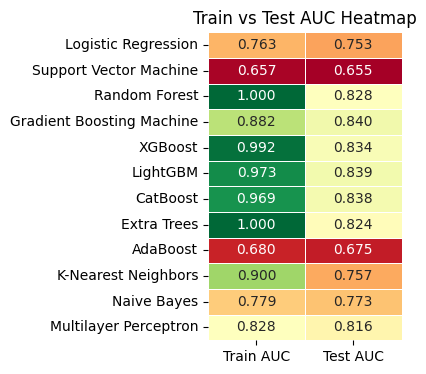

In [33]:
plt.figure(figsize=(2.5, 4))
sns.heatmap(results_df.set_index('Classifier'), cmap='RdYlGn', cbar=False, annot=True, fmt=".3f", linewidths=.5)
plt.title('Train vs Test AUC Heatmap')
plt.xlabel('')
plt.ylabel('')
plt.show()

<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left">

Based on this, Gradient Boosting Machine, XGBoost, LightGBM, CatBoost appear to be the best-performing classifiers, followed by Random Forest and Extra Trees with overfitting. Further hyperparameter tuning could potentially enhance the performance.

Let's submit with base model
    </div>

In [34]:
# Train final model with best hyperparameters
best_clf = lgb.LGBMClassifier(metric='multi_logloss',
                              boosting_type= "gbdt",
                              learning_rate=0.005,
                              n_estimators=800,
                              max_depth=6, num_leaves=252,
                              reg_alpha= 0.002,
                              reg_lambda= 3.5,
                              min_split_gain=0.05,
                              subsample=0.6, verbose=-1)
best_clf.fit(X_train, y_train)

# Final AUC scores
x_pred = best_clf.predict_proba(X_train)
y_pred = best_clf.predict_proba(X_test)

auc_train = roc_auc_score(y_train, x_pred, multi_class="ovr")
auc_test = roc_auc_score(y_test, y_pred, multi_class="ovr")

print(f"Train AUC: {auc_train:.4f}, Test AUC: {auc_test:.4f}")


Train AUC: 0.9437, Test AUC: 0.8978


<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="3"></a>
## <b> <span style='color:#E1B12D'> 🔎 Prediction on Test</span></b> 


In [35]:
# Evaluate  on the test set
pred_proba = best_clf.predict_proba(test)

In [36]:
submission=pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv')
submission[targets] = pred_proba
submission.to_csv("submission.csv", index=False)
submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.536969,0.002361,0.005059,0.000896,0.006405,0.106651,0.341659
1,19220,0.252384,0.011686,0.013632,0.001294,0.191212,0.162388,0.367404
2,19221,0.003044,0.047359,0.071848,0.001951,0.006783,0.326982,0.542032
3,19222,0.205480,0.003062,0.004941,0.001780,0.012207,0.319550,0.452981
4,19223,0.005297,0.003047,0.005225,0.003214,0.005227,0.624054,0.353937


<div style="border-radius:10px; padding: 12px; background-color: #; font-size:120%; text-align:left"> 

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; color:#E1B12D;"> Next ⏭️ </p>

    
✅ Feature Engineering with the parameter<br>
✅ Hypertune the model to optimize<br>
✅ Use other algorithms<br>

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

---
<p style="font-size:20px; font-family:verdana; line-height: 1.7em; color:#E1B12D;">
    <em>Appreciate your time exploring my work. If you enjoyed it, kindly consider upvoting or feel free to drop comment / feedback to help enhance the notebook.<br>
Happy Learning!</em>
</p>

